# Capstone project Chang Liu cl5706

###1. Load the data

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip "/content/gdrive/My Drive/data.zip"

Archive:  /content/gdrive/My Drive/data.zip
  inflating: test/test/testX.pt      
  inflating: train/train/trainX.pt   
  inflating: train/train/trainY.pt   


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
trainx = torch.load('/content/train/train/trainX.pt')

In [ ]:
trainy = torch.load('/content/train/train/trainY.pt')

In [ ]:
testx = torch.load('/content/test/test/testX.pt')

In [ ]:
print(np.shape(trainx[0]))
print(np.shape(trainx[1]))
print(np.shape(trainx[2]))
print(np.shape(testx[0]))

torch.Size([3396, 3, 3, 224, 224])
torch.Size([3396, 3, 224, 224])
(3396,)
torch.Size([849, 3, 3, 224, 224])


In [ ]:
num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


In [ ]:
class LazyLoadDataset(Dataset):    
    def __init__(self, path, train=True, transform=None):
        self.transform=transform
        path = path + ("train/" if train else "test/")
        
        self.pathX=path+"X/"
        self.pathY=path+"Y/"
        self.train=train
        self.data=os.listdir(self.pathX)
        
    def __getitem__(self, idx):
        f=self.data[idx]
        
        #X
        #read rgb images
        img0=cv2.imread(self.pathX + f +"/rgb/0.png")
        img1=cv2.imread(self.pathX + f +"/rgb/1.png")
        img2=cv2.imread(self.pathX + f +"/rgb/2.png")
        if self.transform is not None:
            img0=self.transform(img0)
            img1=self.transform(img1)
            img2=self.transform(img2)
        depth = np.load(self.pathX + f + "/depth.npy")
        field_id = pkl.load(open(self.pathX + f + "/field_id.pkl", "rb"))
        if(self.train==True):
            Y = np.load(self.pathY + f + ".npy")
            return (img0, img1, img2, depth, field_id),Y
        else:
            return (img0, img1, img2, depth, field_id)
    def _len_(self):
        return len(self.data)

In [ ]:
train_x= LazyLoadDataset("./lazydata/", train=True)
test_x= LazyLoadDataset("./lazydata/", train=False)

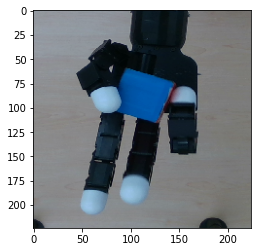

In [ ]:
(img0, img1, img2, depth, field_id), Y= train_x[0]
plt.imshow(img0[:,:,::-1])
#plt.imshow(depth[0])
plt.show()

###2. Data Processing

In [ ]:
#make list for each images
train_img0_ls=[]
train_img1_ls=[]
train_img2_ls=[]
train_depth_ls=[]
train_field_ls=[]
y_ls=[]
for i in range (3396): 
    (img0, img1, img2, depth, field_id), y = train_x[i]
    train_img0_ls.append(img0)
    #train_img1_ls.append(img1)
    #train_img2_ls.append(img2)
    train_depth_ls.append(depth)
    #train_field_ls.append(field_id)
    y_ls.append(y)

In [ ]:
print(len(train_img0_ls))
print(len(train_depth_ls))

3396
3396


In [ ]:
test_img0_ls=[]
test_img1_ls=[]
test_img2_ls=[]
test_depth_ls=[]
test_field_ls=[]
for i in range (849): 
    (img0, img1, img2, depth, field_id) = test_x[i]
    test_img0_ls.append(img0)
    #test_img1_ls.append(img1)
    #test_img2_ls.append(img2)
    test_field_ls.append(field_id)
    test_depth_ls.append(depth)

In [ ]:
import pandas as pd 
print(test_field_ls)
df = pd.DataFrame(test_field_ls)
df.to_csv('/content/id.csv')

['3828', '3062', '1265', '3953', '2101', '2339', '967', '4236', '1267', '2889', '4121', '2182', '2849', '2987', '4203', '1464', '1029', '2898', '3868', '4008', '823', '2481', '36', '2477', '1001', '656', '1586', '381', '3280', '3139', '971', '522', '2084', '871', '2761', '616', '3615', '4093', '4109', '3366', '925', '3479', '811', '3170', '2079', '2427', '1452', '1384', '3088', '598', '1994', '1800', '2171', '907', '3502', '3933', '185', '3719', '711', '373', '2873', '94', '1097', '441', '4180', '3072', '2243', '1827', '734', '964', '1428', '2408', '591', '2797', '2160', '2006', '262', '496', '2261', '3092', '417', '2594', '1254', '3095', '930', '1868', '1741', '306', '382', '4088', '2677', '2679', '3200', '760', '856', '3347', '3855', '111', '315', '3886', '546', '1632', '2805', '2439', '3489', '421', '2289', '3500', '375', '553', '1821', '489', '3750', '3154', '2007', '2288', '3182', '4123', '3671', '3254', '2152', '3427', '3416', '169', '2866', '3346', '104', '3833', '1597', '3572',

In [ ]:
print(len(test_img0_ls))

849


In [ ]:
#normalize the data
#print(train_img0_ls[1])
#print(train_depth_ls)
def depth_normalization(size, depth):
    result=[]
    for i in range (size):
        depth[i]=depth[i]/1000
        min= np.min(depth[i])
        max= np.max(depth[i])
        temp=max-min
        result.append((depth[i] - min) /temp)
    return result
def rgb_normalization(size, rgb):
    result=[]
    for i in range (size):
        result.append(rgb[i]/255)
        # min= np.min(rgb[i])
        # max= np.max(rgb[i])
        # temp=max-min
        # result.append((rgb[i] - min) /temp)
    return result

In [ ]:
train_img0_ls= rgb_normalization(3396, train_img0_ls)
#train_img1_ls= rgb_normalization(3396, train_img1_ls)
#train_img2_ls= rgb_normalization(3396, train_img2_ls)
train_depth_ls= depth_normalization(3396, train_depth_ls)

In [ ]:
#print(train_img0_ls[1])
print(len(train_depth_ls))
print(train_img0_ls[0].shape)

3396
(224, 224, 3)


In [ ]:
test_img0_ls= rgb_normalization(849, test_img0_ls)
#test_img1_ls= rgb_normalization(849, test_img1_ls)
#test_img2_ls= rgb_normalization(849, test_img2_ls)
test_depth_ls= depth_normalization(849, test_depth_ls)

In [ ]:
#reshape img0 and depth into one (3396,4,224,244) array so that it can be the input of model
input_train=np.empty((3396,4,224,224))
for i in range (3396):
    input_train[i,:,:,:]=(np.concatenate((train_img0_ls[i].reshape((3*224*224)),train_depth_ls[i][0].reshape(224*224))).reshape((4,224,224)))


In [ ]:
print(input_train.shape)

(3396, 4, 224, 224)


In [ ]:
input_test=np.empty((849,4,224,224))
for i in range (849):
    input_test[i,:,:,:]=(np.concatenate((test_img0_ls[i].reshape((3*224*224)),test_depth_ls[i][0].reshape(224*224))).reshape((4,224,224)))

In [ ]:
#torch.save(input_test, '/content/input_test.pt')

###3. Train & Test with CNN

In [ ]:
#target*1000
print(input_test.shape)
new_y=[]
for i in y_ls:
  new_y.append(i*1000)

(849, 4, 224, 224)


In [ ]:
print(new_y[0])

[ 46.25663281  54.01882972 123.31949604  93.42128747   4.79585883
  88.95553402  50.04557647 -35.72904457 -26.10380779  83.38424292
  44.12180123 -11.18094372]


In [ ]:
data_train = torch.utils.data.TensorDataset(torch.Tensor(input_train),torch.Tensor(new_y))
train_loader = DataLoader(data_train, batch_size=128, shuffle=True)

<ipython-input-20-4c5992d38f9a>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  data_train = torch.utils.data.TensorDataset(torch.Tensor(input_train),torch.Tensor(new_y))


In [ ]:
class block(nn.Module):
    expansion = 1
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
        block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
        block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
        block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
        block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print('success')
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []
      # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
      # we need to adapt the Identity (skip connection) so it will be able to be added
      # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
          identity_downsample = nn.Sequential(
          nn.Conv2d(
          self.in_channels,
          intermediate_channels * 4,
          kernel_size=1,
          stride=stride,
          bias=False
          ),
          nn.BatchNorm2d(intermediate_channels * 4),
          )

        layers.append(
        block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
          layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

In [ ]:
#For ResNet50 the layer sequence is [3, 4, 6, 3].
def ResNet50(img_channel=4, num_classes=12):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [ ]:
model_cnn=ResNet50(img_channel=4, num_classes=12)
model_cnn=model_cnn.to(device)

In [ ]:
#optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
#optimizer = torch.optim.RMSprop(model_cnn.parameters())
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.01)


In [ ]:
def train(train_loader, epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data,permutation_order)

        optimizer.zero_grad()
        output = model(data.to(device))
        loss = nn.MSELoss()(output.to(device),target.to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

In [ ]:
#!apt install psmisc

In [ ]:
#!sudo fuser /dev/nvidia*

In [ ]:
#!kill -9 630

In [ ]:
for epoch in range (0,30):
  train(train_loader, epoch, model_cnn.to(device), optimizer)

Train Epoch: 0 [0/3396 (0%)]	Loss: 4442.424805
Train Epoch: 1 [0/3396 (0%)]	Loss: 224.016388
Train Epoch: 2 [0/3396 (0%)]	Loss: 214.369720
Train Epoch: 3 [0/3396 (0%)]	Loss: 134.636215
Train Epoch: 4 [0/3396 (0%)]	Loss: 114.902649
Train Epoch: 5 [0/3396 (0%)]	Loss: 82.758080
Train Epoch: 6 [0/3396 (0%)]	Loss: 87.688034
Train Epoch: 7 [0/3396 (0%)]	Loss: 62.057007
Train Epoch: 8 [0/3396 (0%)]	Loss: 60.931023
Train Epoch: 9 [0/3396 (0%)]	Loss: 53.882626
Train Epoch: 10 [0/3396 (0%)]	Loss: 39.901939
Train Epoch: 11 [0/3396 (0%)]	Loss: 42.682701
Train Epoch: 12 [0/3396 (0%)]	Loss: 43.927795
Train Epoch: 13 [0/3396 (0%)]	Loss: 30.271002
Train Epoch: 14 [0/3396 (0%)]	Loss: 39.719849
Train Epoch: 15 [0/3396 (0%)]	Loss: 28.215176
Train Epoch: 16 [0/3396 (0%)]	Loss: 45.079712
Train Epoch: 17 [0/3396 (0%)]	Loss: 24.220350
Train Epoch: 18 [0/3396 (0%)]	Loss: 26.229015
Train Epoch: 19 [0/3396 (0%)]	Loss: 31.105469
Train Epoch: 20 [0/3396 (0%)]	Loss: 38.522141
Train Epoch: 21 [0/3396 (0%)]	Loss: 22

In [ ]:
#torch.save(model_cnn, '/content/model')

In [ ]:
# input_test=torch.Tensor(input_test).to(device)
# torch=model_cnn(input_test)

In [ ]:
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
print(input_test.shape)

(849, 4, 224, 224)


In [ ]:
test_loader = DataLoader(torch.Tensor(input_test).to(device))

In [ ]:
result=[]
for i in test_loader:
  result.append(model_cnn(i))

In [ ]:
len(result)

11

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
print(df)

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Index: []


In [ ]:
for i in range (11):
  temp=result[i][0].to('cpu')
  temp=temp/1000
  df.loc[len(df.index)]=temp.detach().numpy()

print(df)

           1         2         3         4         5         6         7  \
0   0.044913  0.054191  0.122307  0.071777  0.000062  0.102146  0.057254   
1   0.045948  0.053963  0.120883  0.068773  0.000621  0.103769  0.056606   
2   0.045299  0.054078  0.121574  0.067770  0.001307  0.104968  0.055473   
3   0.043860  0.053715  0.121360  0.068521  0.000815  0.104736  0.057252   
4   0.045529  0.054836  0.123229  0.074148  0.000890  0.102707  0.059079   
5   0.046667  0.052843  0.117973  0.071829  0.000733  0.096683  0.056293   
6   0.045780  0.054600  0.122118  0.072969  0.000443  0.102978  0.058975   
7   0.044472  0.052448  0.117577  0.069722  0.000648  0.094871  0.056258   
8   0.046298  0.053674  0.120244  0.073229  0.000020  0.098878  0.057471   
9   0.045870  0.054827  0.123534  0.070457  0.000377  0.105469  0.056645   
10  0.046717  0.053562  0.119713  0.075248  0.000143  0.095562  0.058102   

           8         9        10        11        12  
0  -0.042705  0.048823  0.061942

In [ ]:
df.to_csv('/content/part3.csv')

In [ ]:
second_part=input_test[416:-1,:,:,:]
print(input_test.shape)
print(second_part.shape)

(849, 4, 224, 224)
(432, 4, 224, 224)


In [ ]:

third_part=input_test[837:-1,:,:,:]
print(third_part.shape)

(11, 4, 224, 224)


In [ ]:
#input_test=torch.Tensor(input_test).to(device)
test_loader = DataLoader(torch.Tensor(third_part).to(device))


In [ ]:
model_cnn=torch.load('/content/model')

In [ ]:
result=[]
for i in test_loader:
  result.append(model_cnn(i))

In [ ]:
result=[]
for i in range (418,849):
  result.append(model_cnn(torch.Tensor(input_test[i]).to(device)))

ValueError: ignored

In [ ]:
print(len(result))
print(result[0])

10
tensor([[ 0.0623,  0.0193, -0.0994,  0.0097, -0.1075,  0.2530, -0.0057, -0.0730,
          0.1884,  0.0117,  0.0480,  0.0448]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
temp=result[0][0].to('cpu')
print(temp)

tensor([ 0.2025,  0.0882,  0.0173,  0.2190,  0.0777, -0.0158, -0.1075,  0.0933,
        -0.1307,  0.1570,  0.0140, -0.1290], grad_fn=<ToCopyBackward0>)


In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12'])
print(df)

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Index: []


In [ ]:
for i in range (10):
  temp=result[i][0].to('cpu')
  df.loc[len(df.index)]=temp.detach().numpy()

print(df)

In [ ]:
df.to_csv('/content/part3.csv')